# Analytische oefeningen Voortoets

@Theo Olsthoorn (March 12, 2024)

In [4]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from scipy.special import k0 as K0, j0 as J0, y0 as Y0, exp1 as Wt, jn_zeros, yn_zeros, exp1
from scipy.integrate import quad
from scipy.signal import lfilter, filtfilt
import pandas as pd
from itertools import cycle

## Basisfuncties die verderop worden gebruikt:

In [5]:

def newfig(title, xlabel, ylabel, xlim=None, ylim=None, xscale=None, yscale=None, figsize=None):
    """Set up a new figure with a single axes and return the axes."""
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xscale is not None: ax.set_xscale(xscale)
    if yscale is not None: ax.set_yscale(yscale)
    ax.grid(True)
    return ax


def Wh(u, rho=0):
    """Return Hantush's well function values.
    
    Parameters
    ----------
    u = r^s / (4 kD t)
    rho = r / lambda,    lambda = sqrt(kD c)
    
    >>>Wh(0.004, 0.03)
    4.894104204671381    
    """
    def kernel(y, rho):
        """Return the function to be integrated."""
        return np.exp(-y - (rho / 2) ** 2 / y) / y
    def w(u, rho): # Integrate the argument
        return quad(kernel, u, np.inf, args=(rho,))[0]
    wh = np.frompyfunc(w, 2, 1) # Vectorize function w(u, rho) so we can use arrays as input.
    return np.asarray(wh(u, rho), dtype=float)

Wh(0.004, 0.03)


def Wb(tau, rho=0):
    """Return Hantush well function values using the Bruggeman (1999) form of Hantush's Well function.
    
    Parameters
    ----------
    tau = t/ (cS)
    rho = r / lambda, lambda= sqrt(kD c)
    
    >>>Wb(0.05625, 0.03)
    4.894104204671381    
    """
    def kernel(x, rho):
        """Return the function to be integrated."""
        return np.exp(-x - (rho / 2) ** 2 / x) / x
    def w(tau, rho): # Integrate the argument
        return quad(kernel, 0, tau, args=(rho,))[0]
    wh = np.frompyfunc(w, 2, 1) # Vectorize function w(u, rho) so we can use arrays as input.
    return np.asarray(wh(tau, rho), dtype=float)


def Wb1(tau, rho=0):
    """Return Hantush well function values using the Bruggeman (1999) form of Hantush's Well function.
    
    Parameters
    ----------
    tau = t/ (cS)
    rho = r / lambda, lambda= sqrt(kD c)
    
    >>>Wb(0.05625, 0.03)
    4.894104204671381    
    """
    u = rho ** 2  / (4 * tau)
    return Wh(u, rho)


#u = np.logspace(-4, 1, 51)
u, rho = 0.004, 0.03
print("Wh(u={:.4g}, rho={:.4g}) = {}".format(u, rho, Wh(u, rho)))
tau = rho ** 2 / (4 * u)
print("Wb(tau={:.4g}, rho={:.4g}) = {}".format(tau, rho, Wb(tau, rho)))


Wh(u=0.004, rho=0.03) = 4.894104204671381
Wb(tau=0.05625, rho=0.03) = 4.894104204671358


## De nalijlende verlaging

Hoeveel blijft er na verloop van tijd nog over van een tijdeijke onttrekking in het verleden? Deze vraag is eigenlijk alleen relevant voor de Theis situatie met freatische berging, omdat de semi-gespannen situatie volgens Hantush al snel stationair wordt en dan ook snel geen restantvergelaging meer heeft nadat de onttrekking is gestopt.

De verlaging door een onttrekking in een situatie zonder randvoorwaarden wordt goed beschreven door Theis

$$ \frac Q {2 \pi kD} W(u), \,\,\,\, u =\frac{r^2 S }{4 kD t} $$

Er is in een dergelijke Theis situatie na beëndiging van de onttrekking nog zeer lange tijd sprake van een resterende verlaging, die samen met andere niet permanente onttrekkingen toch tot een cumulatief effect zal leiden.

De resterende verlaging is dan gelijk aan
 $$ s(r, t) = \frac{Q}{4 \pi kD} \left[ W_t \left(\frac{r^2 S}{4 kD t}\right) - W_t \left( \frac{r^2 S}{4 kD (t - \Delta t)} \right)\right]$$

Voorbeeld:


(0.0, 4000.0)

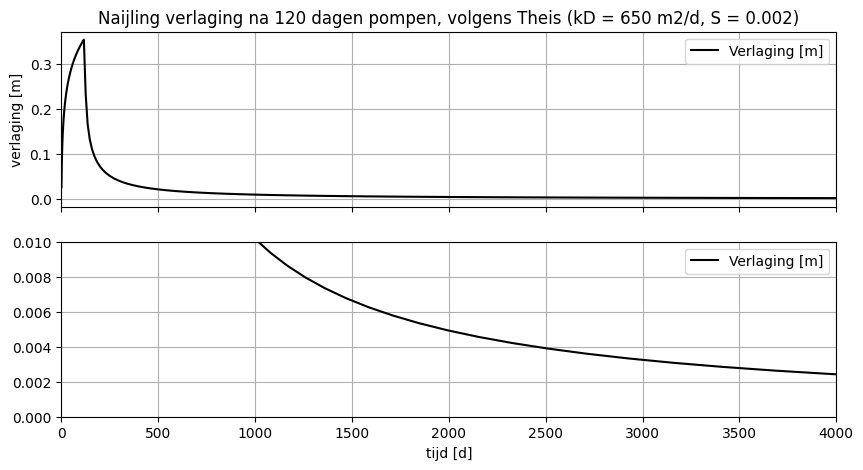

In [6]:
kD, S = 650, 0.002 # [m2/d]
Dt = 120 # [d] Duur van de onttrekking
r = 1000 # [m]
t = np.logspace(0, 4, 121) # [d]

putten = {
    0: {'Q': +650., 'tStart':   0.},
    1: {'Q': -650., 'tStart': 120.}
}

s = np.zeros_like(t)
for k, put in putten.items():
    Q, tStart = put['Q'], put['tStart']
    u = r ** 2 * S  / (4 * kD * (t[t > tStart] - tStart))
    s[t > tStart] += Q / (4 * np.pi * kD) * Wt(u)

fig, axs = plt.subplots(2, 1, figsize = (10, 5), sharex=True)
for ax in axs:    
    ax.grid()
    ax.plot(t, s,  color='k', label='Verlaging [m]')
    ax.legend()
axs[0].set(title='Naijling verlaging na {:.0f} dagen pompen, volgens Theis (kD = {:.0f} m2/d, S = {:.3g})'.format(tStart, kD, S),
           ylabel='verlaging [m]',
            yscale='linear', xscale='linear')
axs[1].set_ylim(0, 0.01)
axs[1].set_xlabel('tijd [d]')
axs[1].set_xlim(0, 4000)

## Het cumulatieve effect van gelijktijdige en in de tijd verschoven onttrekkingen

Bij een groot aantal bemalingen willekeurig in de tijd ontstaat zo een cumulatief effect.

Veronderstel een stad met een oppervlak van 3x3 km, waar op eerste van elke maand op een willekeurige locatie in de stad een bemaling start van 1800 m3/d start, die drie maanden aanhoudt. Dat betekent dat vanaf maand 3 er steeds 3 bemalignen actief zijn elke op een willekeurige locatie in de stad. De bemalingen vinden plaats over een periode van 120 maanden. De periode daarna laat naijling zien. De periode gedurende de beschouwde 120 maanden laat het cumulatieve effect van de bemalingen zien.

De bodemconstantn $kD$ en $S$ zijn zodanig dat bij 1800 m3/d op 10 m afstand na 120 dagfen een verlaging optreedt van 3 m. Dit zijn allemaal redelijke aannamen zoals je die in een stad zou verwachten.



In [7]:
kD, S = 650, 0.002 # [m2/d]
Q, duur, r = 1800, 120, 10

print('Verlaging na {} d, bij Q = {:.0f} m3/d op r = {:.1f} m bij kD ={:.0f} m2/den S = {:.3g} m: = {:.2f} m'.format(
    duur, Q, r, kD, S, Q / (4 * np.pi * kD) * Wt(r ** 2 * S / (4 * kD * duur))))

Verlaging na 120 d, bij Q = 1800 m3/d op r = 10.0 m bij kD =650 m2/den S = 0.002 m: = 3.02 m


De stad met de 100 locaties met een onttreking gedurende drie maanden verdeeld over een periode van 10 jaar.

Elke maand start er een onttrekking op een van de 100 locaties gedurene een periode van 3 maanden. Dit impliceert dat er vanaf maand 3 steeds 3 bemalingen actief zijn op 3 willekeurige locaties van de 100. Het gaat daarom een periode van 43 maanden, waarna alle onttrekkingen zijn gestopt.

In [8]:
# Plot de bemaling op de kaart
tend = 10 * 365

# Kies 120 x,y locaties binnen de stad van 3x3 km.
xy = np.round((np.random.rand(240).reshape(2, 120) - 0.5) * 3000)

# Elke maand start een volgende bemaling
tStart = np.linspace(0, tend, 120).reshape(1, 120)

bemaling = pd.DataFrame(data=np.vstack((xy, tStart)).T, columns=['x', 'y', 'tStart'])
      
bemaling.index.name = 'bemaling'
bemaling['Q']    = -1800 # d
bemaling['duur'] =   90  # d
print(bemaling)

               x       y       tStart     Q  duur
bemaling                                         
0          349.0   491.0     0.000000 -1800    90
1          947.0  1485.0    30.672269 -1800    90
2         -797.0   699.0    61.344538 -1800    90
3         1452.0    20.0    92.016807 -1800    90
4          667.0   371.0   122.689076 -1800    90
...          ...     ...          ...   ...   ...
115        946.0 -1339.0  3527.310924 -1800    90
116       1228.0  -788.0  3557.983193 -1800    90
117        103.0   500.0  3588.655462 -1800    90
118        743.0 -1120.0  3619.327731 -1800    90
119       1458.0  -502.0  3650.000000 -1800    90

[120 rows x 5 columns]


Locaties van de bemalingen

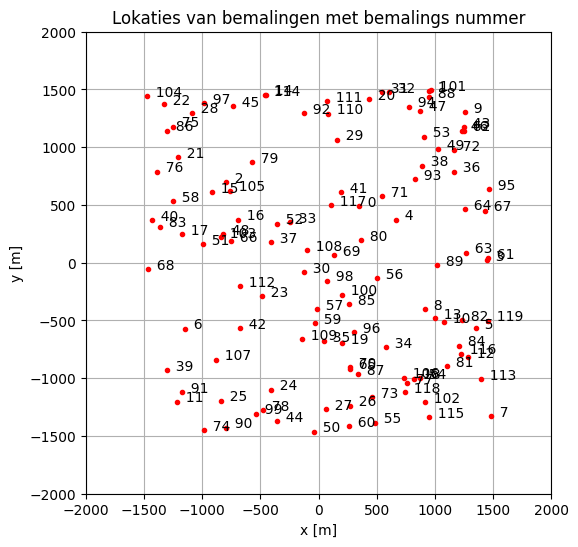

In [9]:
ax = newfig('Lokaties van bemalingen met bemalings nummer', 'x [m]', 'y [m]',
            xlim=(-2000, 2000), ylim=(-2000, 2000), figsize=(6, 6))
ax.plot(bemaling['x'], bemaling['y'], 'r.', label='locatie bemaling')
for nr in bemaling.index:
    x, y, tstart, Q, duur = bemaling.loc[nr] 
    ax.text(x, y, '  {}'.format(nr))


Het cumulatieve effect van de bemalingen

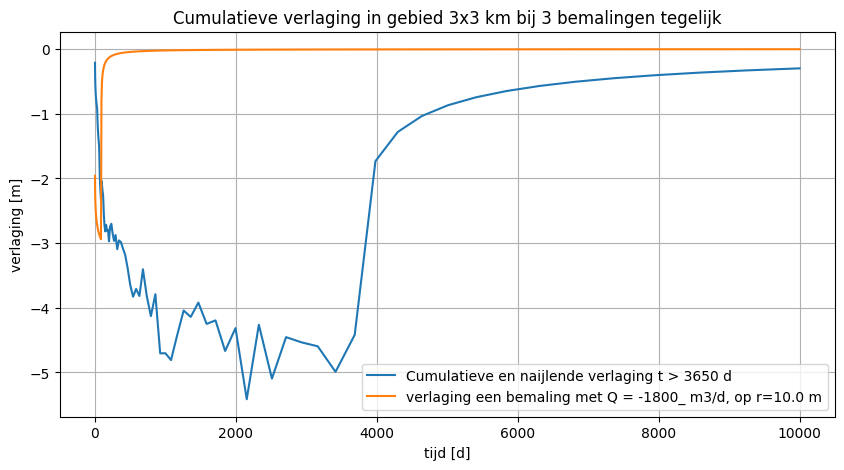

In [10]:
x0, y0 = 0., 0. # [m] locatie van de waarneming

ax = newfig('Cumulatieve verlaging in gebied 3x3 km bij 3 bemalingen tegelijk',
            'tijd [d]', 'verlaging [m]', figsize=(10, 5))

s = np.zeros_like(t)
for k in bemaling.index:
    xw, yw, tstart, Q, duur = bemaling.loc[k]
    r = np.sqrt((xw - x0) ** 2 + (yw - y0) ** 2)
    
    # Put aan
    u = r ** 2 * S  / (4 * kD * (t[t > tstart] - tstart))
    s[t > tstart] += Q / (4 * np.pi * kD) * Wt(u)
    
    # Put uit
    u = r ** 2 * S  / (4 * kD * (t[t > tstart + duur] - (tstart + duur)))
    s[t > tstart + duur] -= Q / (4 * np.pi * kD) * Wt(u)
    
ax.plot(t, s, label='Cumulatieve en naijlende verlaging t > 3650 d')

# Een enkele bemaling 1800 m3/d gedurende 120 d, observatie op r=10 m.
Q, r = -1800, 10

# Put aan op t=0
s = Q / (4 * np.pi * kD) * Wt(r ** 2 * S / (4 * kD * t))

# Put uit op t=90 d
s[t > duur] += -Q / (4 * np.pi * kD) * Wt(r ** 2 * S / (4 * kD * (t[t > duur] - duur)))

ax.plot(t, s, label='verlaging een bemaling met Q = {:.0f}_ m3/d, op r={:.01f} m'.format(Q, r))
    
ax.legend()
    

## Formule van Verruijt versus die van Dupuit

De formule van Verruijt gaat ervan uit dat de onttrekking precies gelijk is aan de neerslag binnen de straal waarop de verlaging nul is. Het is wel heel toevallig wanneer de ontrekking en gebiedsrand met vaste stijghoogte met elkaar overeenkomen.

Men kan ook zeggen dat de formule van Verruijt de verlaging berekent binnen een circulair intrekgebied, het gebied waarbinnen al het water naar de put stroomt. Het intrekgebied wordt begrensd door de cirkel waarop er geen verhang is naar de put. Dit is echter niet de grens van de verlaging die de put veroorzaakt, want die wordt bepaald door de afstand tot de rand met gefixeerde stijghoogte.

Volgens Verruijt is in dit geval de volumestroom $Q_r$ bij putonttrekking $Q$ en neerslagoverschot $N$, gelijk aan

$$ Q_r = - \left(h_0^2 - h_w^2 + \frac N {2k}(R^2 - r^2) \right)\frac{\pi k}{\ln \frac{r}{R}} $$

Dit kan veel eenvoudiger als volgt worden opgeschreven:

$$ Q_r = N \pi r^2 - Q$$

Met als oplossing van Verruijt voor onttrekking uit een pakket met vrije watertafel en vlakke bodem, uit het centrum van een gebied met neerslag :

$$ h(r)^2 = H^2 + \frac N {2k}(R^2 - r^2) + \frac{Q_0}{\pi k}\ln\frac{r}{R} $$

Het is duidelijk dat de radius waarop het verhang nul is, de grens van het intreggebied van de put, wordt bepaald door

$$ Q = N \pi r^2 $$

Het zou wel heel toevallig zijn wanneer de onttrekking gelijk is aan de totale neerslag op het circulare gebied. Alleen dan valt het inttrekgebied van de put samen met de gebiedsrand waar $h=H$. Het plaatje bij de uitleg van de formule van Verruijt in de "Handleiding Berekeningsinstrument bemalingen van een bouwput", pag. 9. staat wel $h(0)=H$, de stijghoogte op de rand en er staat $R$ is de invloedsstraal, de afstand van een vaste rand tot aan de put. 

### Voorbeeld

Een cirkelvormig gebied met neerslag en vaste stijghoogte op de rand met een onttrekking in het centrum.

Zonder onttrekking is er alleen sprake van radiaal symmetrische opbolling waarbij de grondwaterstand alleen horizontaal is in het centrum.

Met onttrekking ontstaat er een intrekgebied rond de put met en straal die afhangt van de onttrekking. Op de rand van het inttrekgebied is het verhang gelijk aan nul. De neerslag buiten het intrekgebied stroot nog steeds af naar de vaste rand. Bij toenemende onttrekking neemt de straal van het inttrekgebied eveneens toe. Op het plaatje hieronder is voor een aantal onttrekkingen de verlagingslijn weergegeven en met een driehoekje de straal van het inttrekgebied. De verlaging, de afstand tussen de blauwelijn voor Q=0 en de betreffende gekleurde lijn is alleen nul op de rand. Het gebied met verlaging reikt altijd tot de rand met vaste stijghoogte en dus verder dan het inttrekkgebied. De formule van Verruijt is dus ongeschikt om het gebied met verlaging af te bakenen.

/var/folders/90/m51x_b713y561gzh2kzy18d00000gq/T/ipykernel_945/2173462310.py:10: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(H ** 2 + N / (2 * k) * (R ** 2 - r ** 2) + Q / (np.pi * k) * np.log(r  / R))


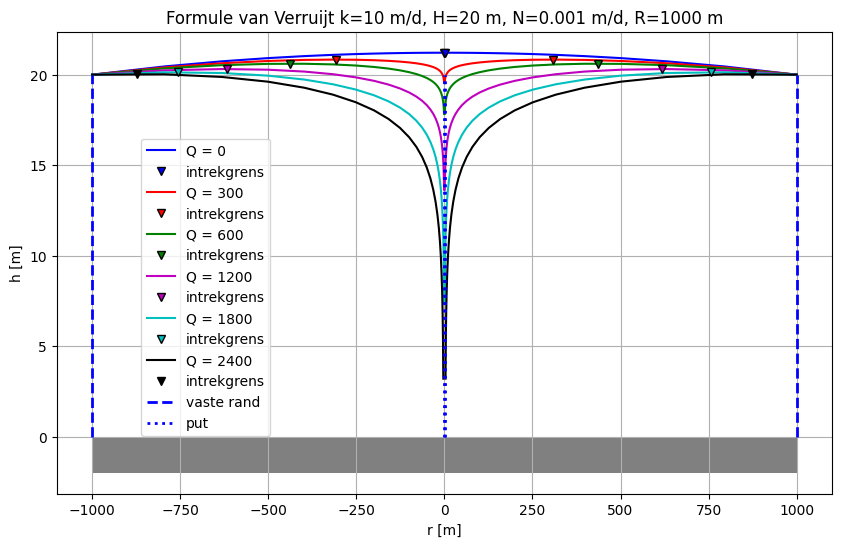

In [12]:
# Bodemconstanten, gebiedsradius, voeding, onttrekking en putstraal
k, H, R, N, Q, rw = 10, 20, 1000, 0.001, 1200, 1.


def h(Q, r):
    """Return stijghoogte bij gegeven onttrekking als functie van de afstand tot de put
    
    Gwbruikt de parameters die hierboven zijn gegeven
    """
    return np.sqrt(H ** 2 + N / (2 * k) * (R ** 2 - r ** 2) + Q / (np.pi * k) * np.log(r  / R))


ax = newfig("Formule van Verruijt k={:.0f} m/d, H={:.0f} m, N={:.3g} m/d, R={:.0f} m".format(
            k, H, N, R),
            "r [m]", "h [m]",
            figsize=(10, 6))

# Kleuren en debieten
clrs = cycle('brgmck')
Qs =[0.001, 300, 600, 1200, 1800, 2400]

r = np.logspace(0, 3, 31)

for Q in Qs:
    clr = next(clrs)    
    # Stijghoogte (links en rechts)
    ax.plot(-r, h(Q, r), color=clr, label='Q = {:.0f}'.format(Q))
    ax.plot(+r, h(Q, r), color=clr, label='')

    # Intrekgebied, radius = rI, links en rechts
    rI = np.sqrt(Q / (np.pi * N))
    ax.plot(-rI, h(Q, rI), ls='none', marker='v', mfc=clr, mec='k', ms=6, label='intrekgrens', zorder=5)
    ax.plot(+rI, h(Q, rI), ls= 'none', marker='v', mfc=clr, mec='k', ms=6, label='', zorder=5)

# Vaste randen
ax.plot([+R, +R], [0, H], '--', color='blue', lw=2, label='vaste rand')
ax.plot([-R, -R], [0, H], '--', color='blue', lw=2, label='')

# Put
ax.plot([+rw, +rw], [0, H], ':', color='blue', lw=2, label='put')
ax.plot([-rw, -rw], [0, H], ':', color='blue', lw=2, label='')

# Pakket bodem
ax.add_patch(patches.Rectangle((-R, -2), 2 * R, 2, fc='gray'))

leg = ax.legend(loc='lower left', fontsize=10)
leg.set_bbox_to_anchor((0.10, 0.11, 0.3, 0.5), transform=ax.transAxes)

### Conclusie formule van Verruijt

De formule van Verruijt is evenzeer van toepassing als die van Dupuit. Waar Dupuit alleen de verlaging berekent of the natte dikte van de de freatische laag zonder neerslag, geeft de formule van Verruijt deze natte dikte van de freatische laag voor ontrekking met neerslag. De verlaging kan nu worden berekend door $h(Q, r)$af te trekken van de h voor $h(Q=0, r)$. Wat wellicht verwarring geeft als gevolg van de figuur in genoemde handleiding, is dat daar in de figuur de cirkel zonder verhang samenvalt met de cirkel met vaste rand. Dat is echter geen beperking in de formule van Verruijt. Deze neemt binnen de vaste rand netjes neerslag en verlaging samen mee voor de situatie waarin de effectieve laagdikte significant verandert.

De verlaging wordt bij Verruijt verkregen door de grondwaterstand met onttrekking af te trekken van die zonder onttrekking. Bij Dupuit en alle andere oplossingen met vaste laagdikte wordt direct de verlaging berekend. De relatie tussen de berekenigen met vaste laagdikte en die met freatische, ruimtelijke laagdikte volgt direct uit de formule van Verruijt door te schrijven:

$$ h^2 - H^2 = (h - H) (h + H) \approx (h - H) 2H = 2 H s $$

Dupuit met neerslag:
$$ s = \frac N {4kH}(R^2 - r^2) + \frac{Q_0}{2 \pi kH}\ln\frac{r}{R} $$

Verruijt
$$ s = \frac N {2k(h + H)}(R^2 - r^2) + \frac{Q_0}{\pi k (h + H)}\ln\frac{r}{R} $$

Bij Verruijt blijft de te berekenen $h$ nog in de noemer staan als je direct de verlaging wilt berekenen. Het verschil tussen beide zit dus in de afwijing van $h$ t.o.v. $H$. Bij een afwijking van 20% is de fout in de berekening ca. 10%; uiteraard kan direct de formule van Verruijt worden gebruikt, of kan de verlaging iteratief worden berekend met de formule hierboven.

# Wanneer worden de verlagingen stationair?

Bij onttrekking met een put in een oneindig uitgestrekt watervoerend paket ontstaat nooit een stationaire eindsituatie omdat er geen terugkoppeling is tussen verlagen en infiltratie.

Verlagingen kunnen alleen stationair worden wanneer ergens in het watervoernde pakket randen zijn met vaste stijghoogte, danwel er een vaste stijghoogte is in een bovenliggend pakket waarmee hydraulische verbinding bestaat via lek door een semi-doorlatende laag. De essentie is dat door de verlaging een stroming wordt opgewekt die op termijn de onttrekking volledig kan compenseren.

De belangrijkste situatie waarbij stationaire stoming optreedt is meestal die met oppervlaktewater verderop in het gebied of een semi-permanente toplaag waarboven het oppervlaktewaterpeil ruimtelijk wordt beheerd.

Voor een put die onttrekt uit een pakket met semi-gespannen water geldt de formule van Hantush (1955)

$$ s(r, t) = \frac{Q}{4 \pi kD} W_h \left(u, \rho\right), \,\,\,\,with\,\,\,\, u = \frac{r^2 S}{4 kD t},\,\,\,\,and\,\,\,\,\rho=\frac{r}{\lambda}$$

Wanneer deze verlaging wordt uitgezet op logartmische tijdschaal blijkt er een buigpunt te zijn halverwege de eindverlaging, waar de verlaging steeds trager naar toe loopt. Het tijdstip van dit buigpunt is een geschikt moment om op praktische wijze de tijd te bepalen waarna de verlaging als stationair mag worden beschouwd.

Het buigpunt ligt op

$$ u = \frac \rho 2 = \frac{r}{2 \lambda}$$

Om het snijpunt van de raaklijn door het buigpunt en de horizontale lijn van de eindverlaging te bepalen, is het mathematisch handiger om direct met de de parameter op de horizontale as te werken

$$ \eta = \ln \left(\frac 1 u \right) = -\ln u $$

De tangent of the raaklijn door de het buigpunt op de as $1/u$ is

$$ \left(\frac{\partial W_h}{\partial \eta} \right) = e^{-\rho}$$

De stationaire eindwaarde is

$$W_h(0, \rho) = 2 K_0(\rho)$$


Waar de raaklijn door het buigpunt de lijn met de eindverlaging snijdt is de verlaging halverwege de eindverlaging behorend bij de stationaire situatie. Het punt waarop de verlaging stationair is geworden kan praktisch worden gedefinieerd als het punt waarop de raaklijn door het buigpunt de horizontale lijn met de eindverlaging snijdt.



$$ \eta = e^{\rho} K_0(\rho) + \eta_{Bp},\,\,\,\,with\,\,\,\,\eta = -\ln(u)$$

$$ \eta_{Bp} = -\ln \left(u_{Bp} \right),\,\,\,\, with\,\,\,\,u_Bp = \frac{\rho}{2}$$

$$\eta - \eta_Bp = e^{\rho} K_0(\rho)$$

$$\frac{e^\eta}{e^{\eta_{Bp}}} = e^{e^{\rho} K_0(\rho)}$$

$$\frac{u_{Bp}}{u} = e^{e^{\rho} K_0(\rho)}$$

Het stijdtip (de $u$-waarde) waarop de verlaging als stationair mag worden beschouwd volgt dus direct uit de $u$-waarde van het buigpunt $u_{Bp}$ en $\rho=r/(2 \lambda)$:

$$ u = u_{Bp}  e^{-e^{\rho} K_0(\rho)}$$

In het voorbeeld hieronder wordt de Hantush functie getoond versus $1/u$ op logaritmische schaal. Het eerste deel van de dubbele buiging start wanneer de invloedsgrens van de onttrekking het waarnemingsput bereikt en het tweede deel wanneer de verlaging wordt afgeremd door de opgewekte lek. De eindverlaging is gelijk aan de stationaire verlaging, zodat, met $t\rightarrow\infty,\,\,u\rightarrow0$:

$$ W_h(0, \rho) = 2 K_0(\rho)$$

Het buigpunt light op halve hoogte, dus bij $W_h(u_{bp}) = K_0(\rho)$. Voor het buigpunt geldt bovendien

$$u_{bp} = \frac{\rho}{2} = \frac{r}{2 \lambda} $$

De berekende buigpunten worden met een dikke stip in de grafiek aangegeven.

Voorts is in de grafieken aangegeven waar de raaklijn door het buigpunt en waar de eindverlaging snijdt (stippelijn met snijpunt).

Het snijpunt van deze raaklijn met de eindverlaging ligt op

$$ u = u_{Bp}  e^{-e^{\rho} K_0(\rho)}$$

Deze gemakkelijk te berekenen waarde van $u$ is een praktische waarde voor het definieren van het moment waarop de eindverlaging is bereikt kan worden beschouwd.

$$ u = \frac{\rho}{2} e^{-{e^\rho} K_0(\rho)}$$

Voor een reële situatie (met het argument in de Theis-formule (geen lek) links staat en de invloed van de lek rechts):

$$u = \frac{r^2 S}{4 kD t}=\frac{r}{2 \lambda} e^{-{e^{\frac{r}{\lambda}} K_0\left(\frac{r}{\lambda}\right)}}$$

of

$$ u = \frac{r^2 S}{4 kD t}=\frac 1 2 \rho e^{-{e^{\rho} K_0(\rho)}}$$

### Voorbeeld

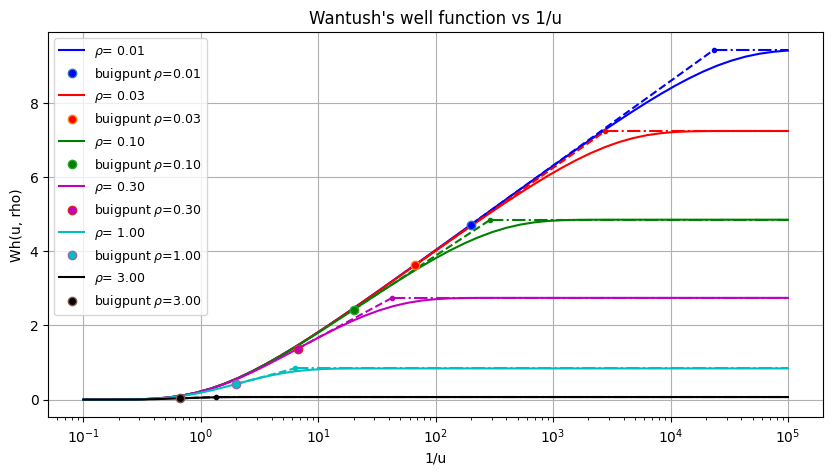

In [13]:
u = np.logspace(-5, 1, 51)
ax = newfig("Wantush's well function vs 1/u", "1/u", "Wh(u, rho)", xscale='log', figsize=(10, 5))

clrs = cycle('brgmck')

rhos = [0.01, 0.03, 0.1, 0.3, 1, 3]

for rho in rhos:
    clr = next(clrs)
    
    # Hantush
    ax.plot(1/u, Wh(u, rho), color=clr, label=r'$\rho$= {:.2f}'.format(rho))
    
    # u-waarde van buigpunt
    uBp = rho  / 2    
    eta2 = np.exp(rho) * K0(rho) - np.log(uBp)
    u2 = np.exp(-eta2)
    
    # Buigpunt
    ax.plot(1 / uBp, Wh(rho / 2, rho), 'o', mfc=clr,  label=r'buigpunt $\rho$={:.2f}'.format(rho), zorder=5.1)    
    
    # Het raaklijn door buigpunt --- lijn
    ax.plot([1 / uBp, 1 / u2], [K0(rho), 2 * K0(rho)], '.--', color=clr, label='', zorder=4.9)
    
    # Eindverlaging -.-.- lijng
    ax.plot([1 / u2, 1 / u[0]], [2 * K0(rho), 2 * K0(rho)], '-.', color=clr, label='', zorder=5)

ax.legend(loc='upper left', fontsize=9)


## Onvolkomen put

Een onvolkomen put veroorzaakt op kortere afstanden van de put een afwijking van de verlaging ten opzichte van de situatie met een put met een filter over de gehele dikte van de watervoerende laag. Onvolkomen filters zijn echter de gangbare situatie, met name in dikkere pakketten.

We kunnen de invloed van de onvokomenheid van het putfilter verwerken met een correctie van Hantush. Deze correctie kan gewoon worden meegenomen in de analytische oplossing.

### Nog uitwerken.

# Vertraagde nalevering (Delayed yield)

Pompproeven die als basis voor aanvragen van vergunningen worden uitgevoerd, zijn vaak zo kort dat alleen de verlaging in het bepompte pakket kan worden bepaald, en geen informatie wordt verkregen van het later nazakken van het freatisch vlak boven de scheidende laag, die optreedt als gevolg van de door het pompten toegenomen lek. De voortoets zou altijd moeten eisen dat dit effect van nazakken wordt meegenomen in de analyse.

$$ s = \frac Q {4 \pi kD} W(u) = \frac Q {2 \pi kD} K_0 \left(\frac r \lambda \right) $$

$$ W(u) = 2 K_0 \left(\frac r \lambda \right) $$

$$ \ln \left( \frac {2.25 kD t}{r^2 S_y} \right) = 2 K_0 \left(\frac r \lambda \right) $$

$$t = \frac{r^s S_y} {2.25 kD} e^{2 K_0 \left( \frac r \lambda \right)}$$

De algemene situatie met vertraagde naverling kan voor het semi-gespannen pakket worden benaderd door de aanvankeijke verlaging volgens Hantush met de elastische bergingscoëfficiënt S, gevolgd door de verlaging volgens Theis met de freatische bergingscoëfficiënt wanneer de verlaging volgens Theis die volgens Hantush inhaalt. Vanaf dat moment zijn de verlaging in het ondiepe en diepe pakket geijk, en lopen samen verder op. In de werkelijkheid ontstaat een vloeiende overgang van de Hantush verlaging naar die volgens Theis, die met een tweelagen model kan worden berekend. Dat is wat ignewikkelder. Voor de praktijk kan de hier gevolgde methode als benadering worden gebruikt. Hij laat in elk geval zien hoe lang men een pompproef doen om zeker te weten dat er in later stadium geen substantiële daling van het freatisch vlak optreedt.


Voorbeeld:

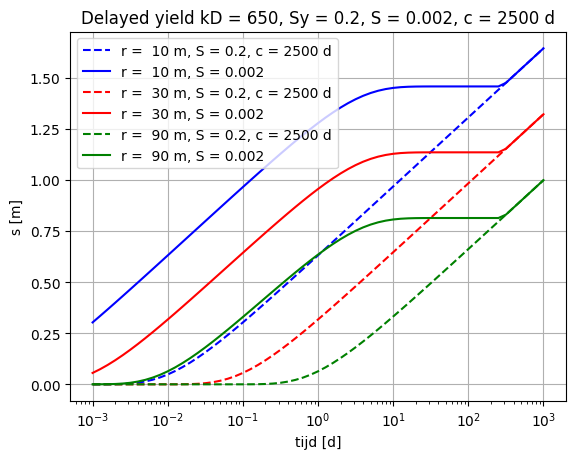

In [14]:
kD, Sy,S, c, Q0 = 650, 0.2, 0.002, 2500., 1200
L = np.sqrt(kD * c)

t = np.logspace(-3, 3, 61)
rs = [10, 30, 90]

ax = newfig("Delayed yield kD = {:.0f}, Sy = {:.3g}, S = {:.3g}, c = {:.0f} d".format(kD, Sy, S, c),
            "tijd [d]", "s [m]",xscale='log')
clrs = cycle('brgmck')
for r in rs:
    clr = next(clrs)
    rho = r  / L
    tx = r ** 2 * Sy / (2.25 * kD) * np.exp(2 * K0(rho))
    u1 = r ** 2 * Sy / (4 * kD * t)
    u2 = r ** 2 * S  / (4 * kD * t)    
    s1 = Q0 / (4 * np.pi * kD) * Wt(u1)
    s2 = Q0 / (4 * np.pi * kD) * Wh(u2, rho)    
    s2[t > tx] = s1[t > tx]
    ax.plot(t, s1, ls='--', color=clr, label='r = {:3.0f} m, S = {}, c = {:.0f} d'.format(r, Sy, c))
    ax.plot(t, s2, ls= '-', color=clr, label='r = {:3.0f} m, S = {}'.format(r, S))
ax.legend()
plt.show()



# Worst case = "Je mag het niet missen, wanneer de voorgenomen ingreep serieuze gevolgen heeft"

### Hoe vullen we dat in??

# Grondwaterbalans. Hoe hiermee omgaan in de passende beoordeling?

Dit gaat onder andere om indirect, via het grondwater, onttrekken aan beken met beperkte afvoer, die in de zomer kwetsbaar zijn. Dit speelt in het algemeen op hogere gronden waar geen externe aanvoer naar het oppervlaktewater kan plaats vinden, dus waarin al het oppervlaktewater afkomstig is van toestromend grondwater.

De onttrekking eigent zich water toe dat anders een andere bestemming zou vinden, zoals voeding van beken en of van de vegetatie. Er zijn derhavle atijd gevolgen van een onttrekking voor de waterbalans van het gebied waarop de ontrekking invloed uitoefent. Men kan berekenen hoeveel indirect via het grondwater aan een naburige beek wordt onttrokken, repectievelijk aan voeding wordt ontnomen. Met name kleinere beken zijn gevoelig voor aanpalende grondwateronttrekkingen. Regionaal kan het cumlatieve effect grote negatieve gevolgen hebben voor de beekafvoer en daarmee voor de ecologie en andere gebruiksdoelen. In de literatuur zijn vele voorbeelden te vinden waarin beken en hele rivieren droog zijn gevallen door onttrekking van grondwater.

# GxG kaart. Welke rol kan die spelen bij de passende beoordeling?

Kan hiermee Vlaanderen worden verdeeld in grondwatergebiedstypen: Infiltratiegebied, intermediar en kwelgebied? Zulke kaareten geven aan wat er als natuurlijke variatie in de grondwaterstand beschouwd kan worden.

Er kan voor de beoordeling van vergunningaanvragen rekening worden gehouden met het type grondwatersysteem: infiltratiegebied (hoog gelegen met diepe grondwaterstand, weinig of geen drainagemiddelen of natuurlijke afvoer) en een kwelgebied (relatief laag gelegen ten opzichte van de omgeving, met hoge grondwaterstanden en veel drainagemiddelen), danwel een overgangsgebied tussen deze twee uitersten in. Naar verwachting zullen toekomstige GxG kaarten deze gebiedsindeling weerspiegelen. De gevolgen van een onttrekking in de verschillende zones zullen ook verschillen. Zo zal een onttrekking in een infiltratiegebied ogenschijnlijk nabij nauwelijks invloed hebben maar zal de invloed verderop manifesteren in het droogvallen van koppen van beken, en van sloten in het overgangsgebied. Deze kunnen daar heel gevoelig voor zijn, terwijl het een op een aantonen van deze effecten aan de hand van metingen wordt bemoeilijkt door de grote natuurlije variatie van de afvoer van de beekkoppen en de van nature variënde slootpeilen in de overganszone. De reikwijdte van de invloed van de onttrekking in een infiltratiegebied is in het algemeen groot doordat de randen die de invloed dempen ver weg liggen.

De situatie bij een onttrekking in een kwelgebied met veel oppervlaktewater, dat stevig gevoed wordt door kwel uit de verre omgeving en (dus uit een groot gebied) is omgekeerd. De reikwijdte is door het vele dempende oppervlaktewater in de naaste omgeving beperkt, zowel wat de verlaging betreft als wat betreft de invloed op het oppervlaktewater.

De situatie in de overgangszone ligt hier tussenin. Beken en sloten tegen het hogere gebied aan zijn zeer gevoelig voor de onttrekking, voor die in de richting het kwelgebied is dit juist minder het geval. De invloed van de onttrekking en zijn reikwijdte is daarom asymmetrisch, hij is groter richting het infiltratiegebied en kleiner richting het kwelgebied.

Deze nuances zijn analytisch moeilijk te benaderen. Een model heeft hier echter geen moeite mee.
Analytisch zou men de invloedsradius kunnen kiezen afhankelijk van het gebiedstype, af te leide uit de GxG kaarten. Een methode hiervoor zou moeten worden uitgewerkt en getoetst aan een aantal representatieve situaties.

# Invloedszone (radius of influence)

Om de in de tijd toenemende reikwijdte van een onttrekking aan te geven wordt wel gesproken van invloedsgrens of "radius of influence". Deze "radius of influence" bij een continue onttrekking in een zich oneindig uitstrekkend watervoerend pakket zonder lek kan direct worden afgeleid uit de verlaging volgens Theis, die in dit geval van toepassing is. De verlaging volgens Theis kan voor voldoende grote tijd worden benaderd met de vereenvoudigde formule met daarin de logarithme in plaats van de well function:

$$ s = \frac Q {4 \pi kD} \ln\left(\frac{2.25 kD t}{r^2 S}\right) $$

Voor het nog niet beïnvloede gebied geldt dat de verlaging nog nul is. Dit is hier (bij benadering) het geval wanneer het argument onder de logaritme gelijk is aan 1:

$$ \frac{2.25 kD t}{r^2 S} = 1 $$

zodat daar een "radius of influence" uit volgt, die gelijk is aan

$$ r = \sqrt{\frac {2.25 kD t}{S}} $$ 

Deze formule is een eenvoudige doch uitermate praktisch uitdrukking om de radius te bepalen waarbuiten de invloed van de onttrekking nog niet bemerkbaar is. Het is een benadering, omdat de gebruikte formule van de verlaging een benadering is, maar het is een praktische benadering die op de aangegeven wijze objectief is afgeleid. Hieronder volgt een voorbeeld waarin de werking van deze radius inzichtelijk wordt gemaakt. 

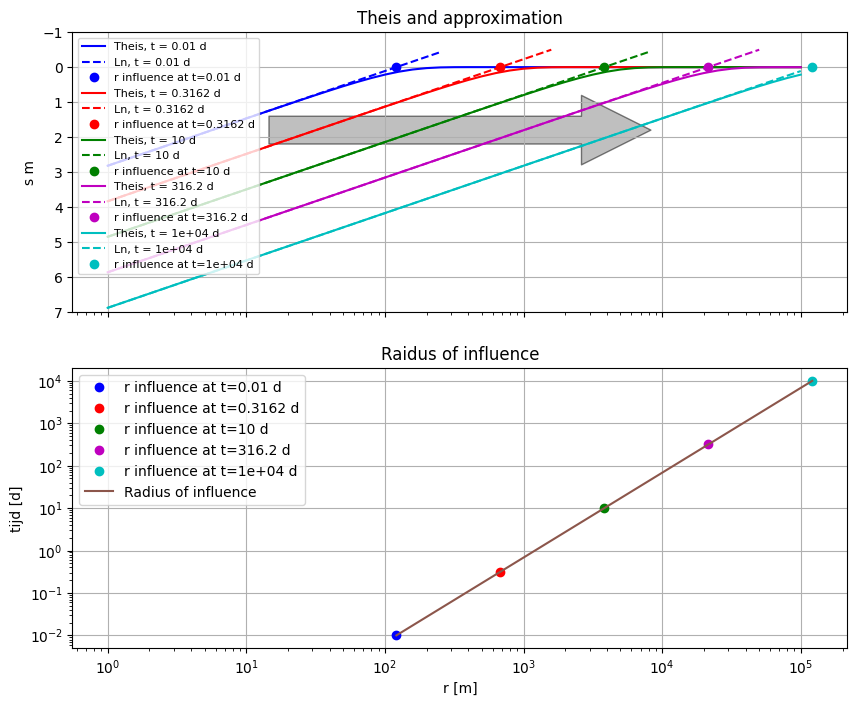

In [15]:
kD, S, Q0 = 650, 0.001, 2400

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True )
axs[0].set_title('Theis and approximation')
axs[0].set_ylabel('s m')
axs[0].grid()
axs[0].set_xscale('log')
axs[0].set_ylim(7, -1)
axs[1].set_title('Raidus of influence')
axs[1].set_ylabel('tijd [d]')
axs[1].set_xlabel('r [m]')
axs[1].set_yscale('log')
axs[1].grid()

r = np.logspace(0, 5, 51)
ts = np.logspace(-2, 4, 5)

clrs = cycle('brgmck')
for t in ts:
    clr = next(clrs)
    u = r ** 2 * S  /( 4 * kD * t)
    sTheis = Q0 / (4 * np.pi * kD)* Wt(u)
    sLn    = Q0 / (4 * np.pi * kD) * np.log(2.25 * kD * t / (r ** 2 * S))
    axs[0].plot(r, sTheis, ls='-',  color=clr, label='Theis, t = {:.4g} d'.format(t))
    axs[0].plot(r[sLn > -0.5], sLn[sLn > -0.5],    ls='--', color=clr, label='Ln, t = {:.4g} d'.format(t))
    rinf = np.sqrt(2.25 * kD * t / S)
    axs[0].plot(rinf, 0, 'o', mfc=clr, mec=clr, label='r influence at t={:.4g} d'.format(t))
    axs[1].plot(rinf, t, 'o', mfc=clr, mec=clr, label='r influence at t={:.4g} d'.format(t))
    
arrow = patches.FancyArrowPatch((0.25, 0.65), (0.75,0.65), transform=axs[0].transAxes,
                                mutation_scale=100, fc='gray', ec='black', alpha=0.5)
#arrow = patches.FancyArrowPatch((0.25, 0.75), (0.75,0.75), transform=fig.transFigure, fc='gray', ec='black', alpha=0.5)
axs[0].add_patch(arrow)
axs[0].legend(loc='upper left', fontsize=8)

tt = np.logspace(-2, 4, 61)
rinf = np.sqrt(2.25 * kD * tt / S)
axs[1].plot(rinf, tt, label='Radius of influence')
axs[1].legend()
plt.show()

### Berekening van de verlaging met convolutie

Convolutie is een algemene method waarmee het dynamische verloop van dde grondwaterstand of verlaging kan worden berekend die volgt uit een in de tijd variërende onttrekking of andere stress zoals neerslagoverschot. Convolutie is in feite een slimme manier van superpositie, waarmee in eenslag een hele tijdreeks kan worden berekend.

De stanaard oplossingen voor het niet-stationaire verloop van de verlaging door een stationaire onttrekking zijn op te vatten als stapresponses wanneer de onttrekking gelijk aan 1 wordt genomen. Bijvoorbeeld de verlaging volgens Theis. De staprespons volgens theis is dan

$$SR = \frac{1}{4 \pi kD} W_t(u) = \frac 1 {4 \pi kD}\intop_u^\infty \frac{e^{-y}}{y} dy,\,\,\,u=\frac{r^2 S}{4 kD t}$$

Hieruit volgt de zogenoemde impulsrespons door differentiatie

$$ IR = \frac{\partial}{\partial t} SR = \frac Q {4 \pi kD} \frac{e^{-u}}{t}$$

De impulsrespons heeft een groot theoretisch belang, maar is voor ons niet nodig. Belangrijker in de praktijk is de staprespons die het gevolg is van een continue onttrekking van 1 m3/d vanaf t=0 en de daaruit afgeleide blokrespons die de reactie is van de grondwaterstand op een plotseling onttrekking van 1 m3/d gedurende exact 1 tijdstap (meestal een dag)

$$ BR = \frac Q {4 \pi kD} \left[ W_t\left({u_t}\right) - W_t\left({u_{t-dt}}\right)\right] $$

De berekening van de verlaging door een willekeurig verlopend debiet geschiedt het gemakkelijkst met de functie `lfilter(...)` uit de module`scipy.signal`.

$$s(r,t) =  \frac{1}{4 \pi kD} \sum_{i=0}^\infty Q(t - \tau_i) BR(\tau_i)
=lfilter \left(BR(\tau, 1, Q(t-\tau)) \right)$$

Het werken met de blokrespons is doorgaans het meest effectief. Het is hetzelfde als convolutie.


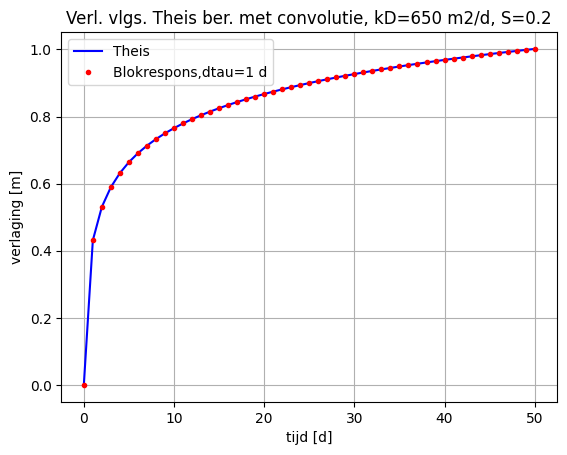

In [143]:
kD, S, Q0 = 650, 0.2, 1200

# Piezometer
r = 20

# Tijd
tauEnd, dtau = 50., 1
tau = np.arange(0, tauEnd + dtau, dtau)

# Berekening verlaging Theis met convolutie
u = r ** 2 * S / (4 * kD * tau[1:])
SR = np.hstack((0, 1 / (4 * np.pi * kD) * Wt(u)))
BR = np.hstack((0, SR[1:] - SR[:-1]))
Q = Q0 * np.ones_like(tau)
sBR = lfilter(BR, 1, Q)  # Convolutie

# Theis jgebruik makend van de formule (= SR, staprespons)
sTh = Q  * SR

title = f"Verl. vlgs. Theis ber. met convolutie, kD={kD:.0f} m2/d, S={S:.3g}"
ax = newfig(title, "tijd [d]", "verlaging [m]")

clrs = cycle('brgmck')
ax.plot(tau, sTh, color=next(clrs), label='Theis')
ax.plot(tau, sBR, '.', color=next(clrs), label=f'Blokrespons,dtau={dtau:.3g} d')
ax.legend()

De berekening van de verlaging met convolutie middels de blokrespons geeft dus hetzelfde resultaat als de analytische oplossing van Theis. Dit moet ook zo zijn.

### Convolutie met de impulsrespons

Hieronder wordt Theis opnieuw berekend maar nu met zowel de blokrespons als de impulsrepons. Voor grote tijdstappen blijkt de impulsrespons veel te kleine waarden op te leveren, pas bij tijdstappen kleinder dan 0.03 komen beide berekeningen goed met elkaar overeen.

In de praktijk gebruiken we altijd de blokrespons, want die is exact en niet afhankelijk van de grootte van de tijdstap.

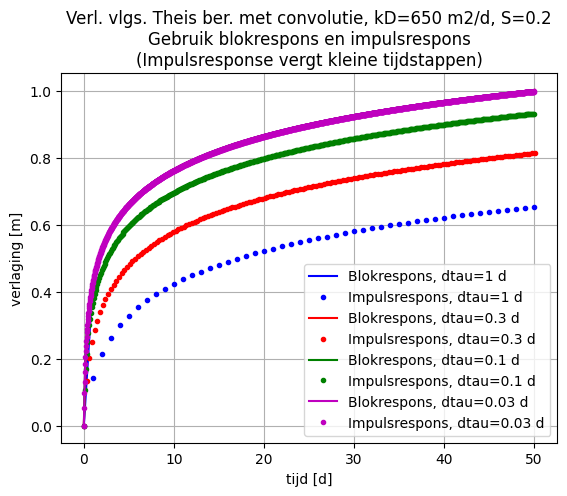

In [145]:

title = f"Verl. vlgs. Theis ber. met convolutie, kD={kD:.0f} m2/d, S={S:.3g}\nGebruik blokrespons en impulsrespons\n(Impulsresponse vergt kleine tijdstappen)"
ax = newfig(title, "tijd [d]", "verlaging [m]")
clrs = cycle('brgmck')
dtaus = np.array([1, 0.3, 0.1, 0.03])
for dtau in dtaus:
    clr = next(clrs)
    tau = np.arange(0., tauEnd + dtau, dtau)
    u = r ** 2 * S / (4 * kD * tau[1:])
    SR = np.hstack((0, 1. / (4 * np.pi * kD) * Wt(u)))
    BR = np.hstack((0, SR[1:] - SR[:-1]))
    sT = np.zeros_like(tau)    
    sT = Q0 * SR
    ax.plot(tau, sT, color=clr, label=f'Blokrespons, dtau={dtau:.3g} d')
    
    # Gebruikt de impulsrespons: Werkt alleen voor voldoend kleine stapgrootte.
    IR = np.hstack((0, 1 / (4 * np.pi * kD) *  np.exp(-u) / tau[1:]))* dtau
    Q = Q0 * np.ones_like(tau)
    sIR = lfilter(IR, 1, Q)
    ax.plot(tau, sIR, '.', color=clr, label=f'Impulsrespons, dtau={dtau:.3g} d')

ax.legend()
plt.show()


We kunnen nu, met convolutie met de blokrespons nauwkeurig de verlaging bij elk willekeurig verloop van de onttrekking uittrekenen.

### Enkele voorbeelden van convolutie met niet constante onttrekking

1. Willekeurig verloop van de onttrekking
2. Onttrekking neemt lineair af in de tijd, waarbij de onttrekking gehalveerd wordt over een tijdvak T
3. Onttrekking neemt exponentiaal af in de tijd, waarbij de onttrekking halveeft over een tijdvak T

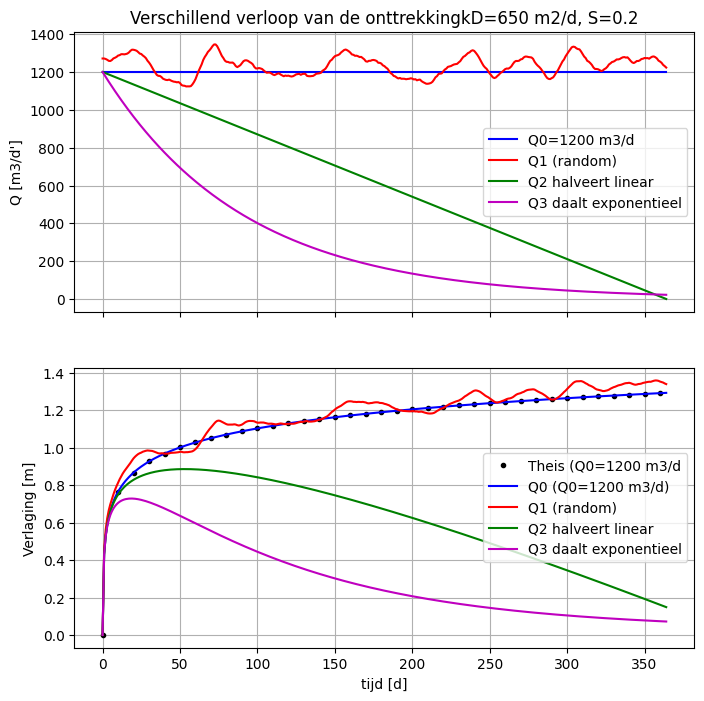

In [60]:
kD, S, Q0 = 650, 0.2, 1200

r = 20 # Piezometer

dtau = 1.0
tauEnd = 365
tau = np.arange(0, tauEnd, dtau)
T = tauEnd / 4
Q  = np.ones_like(tau) * Q0

# Random Q
Q1= Q0 * (np.random.rand(len(tau)) + 0.5)

# Voortschrijdend gemiddelde over 4% van de tijdstappen om een meer vloeiende curve te krijgen
B = np.ones(int(tauEnd / 25))

# Normaliseer, zodat de gemiddelde Q0 behouden blijft
B /= len(B)

# Vlak het random verloop van de onttrekking uit door
# voortschrijdend gemiddelde naar links en naar rechts te nemen
Q1 = filtfilt(B, 1, Q1, method='gust', irlen=len(B))

# Lineair in de tijd afnemend debiet
Q2 = np.interp(tau, np.array([0., tau[-1]]), np.array([Q0, 0]))

# In de tijd exponentieel afnemend debiet
Q3 = Q0 * np.exp(- tau / T)


u = r ** 2 * S  / (4 * kD * tau[1:])
SR = np.hstack((0, 1 / (4 * np.pi * kD) * Wt(u)))
BR = np.hstack((0, SR[1:] - SR[:-1]))

sT = Q0 * SR
s0 = lfilter(BR, 1.0, Q)  # Constante onttrekking
s1 = lfilter(BR, 1.0, Q1) # Uitgevlakt willekeurig verlopende onttrekking
s2 = lfilter(BR, 1.0, Q2) # Lineair in de tijd afnemende onttrekking
s3 = lfilter(BR, 1.0, Q3) # Exponentieel in de tijd afnemende onttrekking

# Plots
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].set_title(f"Verschillend verloop van de onttrekkingkD={kD:.0f} m2/d, S={S:.3g}")
axs[0].set_ylabel("Q [m3/d']")
axs[1].set_ylabel("Verlaging [m]")
axs[1].set_xlabel("tijd [d]")
axs[0].grid()
axs[1].grid()

clrs = cycle('brgmck')

axs[0].plot(tau,  Q, color=next(clrs), label='Q0={:.0f} m3/d'.format(Q0))
axs[0].plot(tau, Q1, color=next(clrs), label='Q1 (random)')
axs[0].plot(tau, Q2, color=next(clrs), label='Q2 halveert linear')
axs[0].plot(tau, Q3, color=next(clrs), label='Q3 daalt exponentieel')

clrs = cycle('brgmck')

axs[1].plot(tau[::10], sT[::10], 'k.', label='Theis (Q0={} m3/d'.format(Q0))
axs[1].plot(tau, s0, color=next(clrs), label='Q0 (Q0={:.0f} m3/d)'.format(Q0))
axs[1].plot(tau, s1, color=next(clrs), label='Q1 (random)')
axs[1].plot(tau, s2, color=next(clrs), label='Q2 halveert linear')
axs[1].plot(tau, s3, color=next(clrs), label='Q3 daalt exponentieel')

axs[0].legend()
axs[1].legend()



### Welke onttrekking is nodig om de gewenste verlaging op een gegeven afstand te handhaven?

Bemalingen hebben als doel een verlaging op de gewenste plek te bereiken om droog te kunnen werken en bouwen. Er zal normaliter een voldoende hoog debiet worden ingezet om in een beperkte tijd de vereiste verlaging te halen. Daarna zal het debiet worden verminderd om de verlaging te behouden tot aan het einde van het project. Zonder deze vermindering van het debiet zal de verlaging verder oplopen. Kunnen we het verloop van het debiet gedurende de gehele duur van de bemaling berekenen?

De analytische formules die ons ter beschikking staan vergen alle een bepaald onttrekkingsdebiet, waarvan de verlaging dan het gevolg is. Er zijn geen analytische formules die de verlaging opleggen en daarbij het in de tijd verlopende bemalingsdebiet uitrekenen. Omgekeerd, het is niet moeilijk om het tijdsverloop van een verlaging te berekenene voor de situatie waarin de onttrekking willekeurig in de tijd varieert; dit kan immers met behulp van convolutie. De omgekeerde situatie is gecomplicdeerder door het gebrek aan een formule die bij gegeven verlaging het bijbehorende verloop van het debiet in de tijd berekent. Om dit toch te brekenen is een iteratief proces een mogelijkheid.

Hieronder wordt een zeer eenvoudige procedure voorgefsteld en uitgwerkt om de gewenste verlaging op geggeven afsand te handhaven. De methode is niet exact maar wel een goede en praktische benadering.

De verlaging in de tijd in de situatie van Theis is

$$ s(r,t) = \frac{Q_0}{4 \pi kD} W(u), \,\,\,\,\, u = \frac{r^2 S}{4 kD t} $$

We kunnen dus de $Q(r,t)$ berekenen die de verlaging $s(r,t)$ de gewenste waarde geeft. Om de verlaging op de gewenste waarde te houden moet $Q$ op een bepaalde wijze in de tijd variëren. Hoe we deze Q(r,t) precies kunnen berekenen weten we niet, maar we kunnen de constante Q die nodig is om de verlaging $s(r,t)% te bereiken wel berekenenen voor elk tijdstip $t$ en deze in de tijd variërende Q als de gezochte benadering beschouwen, die uiteraard steeds nauwkeuriger wordt naarmate de tijd verder voortschrijdt.

Dit wordt hieronder uitgewerkt en grafisch geverifieerd.

/var/folders/90/m51x_b713y561gzh2kzy18d00000gq/T/ipykernel_945/1272070041.py:15: RuntimeWarning: divide by zero encountered in divide
  Q = s * (4 * np.pi * kD) / Wt(u)


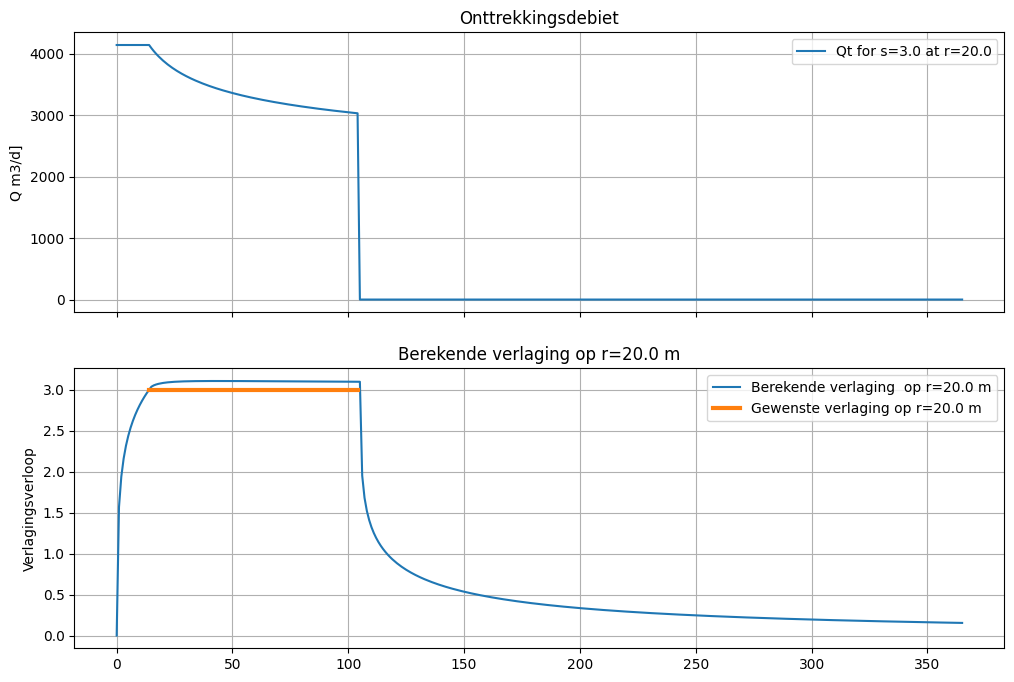

In [122]:
# Parameters aquifer
kD, S = 600, 0.2

t = np.arange(366.0)
t[0] = 1e-6 # Voorkom deling door nul

# Gewense verlaging and afstand waarop deze moet gelden
s, r =3.0, 20.

# Periode  van gewenste verlaging
t1, t2 = 14, 14 + 90 

# Berekening van Q(r,t)
u = r ** 2 * S / (4 * kD * t)
Q = s * (4 * np.pi * kD) / Wt(u)

# Initiële periode, opstarten bemaling tot gewenste verlaging
Q[t <= t1] = Q[t <= t1][-1]

# Periode nadat bemaling beëndigd is
Q[t > t2] = 0.

# Convolutie: Staprespons en blokrespons
SR = np.hstack((0, 1 / (4 * np.pi * kD) * Wt(u[1:])))
BR = np.hstack((0, SR[1:] - SR[:-1]))

# Exacte berekening van de verlaging bij de boven berekende onttrekking
st = lfilter(BR, 1, Q)

# Weergave
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12, 8))
ax1.set_title("Onttrekkingsdebiet")
ax2.set_title(f"Berekende verlaging op r={r} m")
ax1.set_ylabel("Q m3/d]")
ax2.set_ylabel("Verlagingsverloop")
ax1.grid(True)
ax2.grid(True)
ax1.plot(t, Q, label=f"Qt for s={s} at r={r}")
ax2.plot(t, st, label=f"Berekende verlaging  op r={r} m")
ax2.plot([t1, t2], [s, s], lw=3, label=f'Gewenste verlaging op r={r} m')
ax1.legend()
ax2.legend()

De aanloopperiode is die waarin de grond onder de te realiseren bouwput wordt leeggepompt met constant debiet om de bemaling in eerste instantie te realiseren. Dan volgt een periode waarin de verlaging wordt gehandhaafd, waarbij het debiet geleidelijk in de tijd daalt. De laatste tak van de grafiek is de periode na afloop van de bemaling.


#### Conclusie

We zien dat het berekende verlagingsverloop bij de berekende in de tijd verlopende onttrekking maar zeer gering afwijkt van de gewenste constante verlaging op de gegeven afsfand van het hart van de bouwput. We zien ook dat de onttrekking in de tijd moet afnemen om de verlaging op het gewenste niveau te handhaven. De afname blijkt met 25% af te nemen over de 90 dagen die hier zijn aangenomen als duur van de bemaling.

Er bestaat een formule voor het debiet tussen twee ringen wanneer het peil (de verlaging) op de binnenste ring op $t=0$ met een vaste waarde verandert (Zie Carslaw & Jaeger (1959)). Er is ook een rapport van de USGS (Bennet & Patten (1964)) waarin dit vraagstuk wordt behandeld en analytisch wordt opgelost. Echter de formule met zeer slecht convergerende besselfuncties is nauwelijks te integreren. Mijn conclusie is dat de hier voorgestelde benadering veel praktischer is en nauwkeurig genoeg. Onnauwkeurigheden door onvoldoende kennis van de bodemconstanten of door variërend debiet of minder goed afgesteld debiet of door neerslag tijdens de bemaling zullen groter zijn dan de fout die met de hiervoor uitgewerkte berekeningsmethode wordt gemaakt.


### Bennett, GD, Patten EP (1964) Groudnwater hydraulics. Constant-head pumping test of a muliaquifer well to determine characteristics of individual aquifers.USGS Water-Supply Paper 1536-G, Washington 1962.

$$G(\beta) = \frac {4 \beta}{\pi} \intop_{x=0}^{\infty} xe^{-\beta x^2} \left[\frac \pi 2 + \arctan \frac{K_0(x)}{J_0(x)}\right]dx$$

Dit zou de onttrekking in de tijd moeten zijn bij constante verlaging op afstand $r$

$$ Q(t) = 2 \pi kD\,H \, G\left(\frac{kDt}{r^2S }\right)$$


### Ferris, JG, Knowles DB, Brrown RH and Stallman RW (1962) Theory of aquifer tests. US Geologial Survey Water Supply Paper 1536-E

Dit is een iets eerder document met in essentie dezelfde oplossing.

Op pagina 110 en volgende staat:

$$Q = 2 \pi T s_w G(\alpha)$$
$$G(\alpha) = \frac{4 \alpha}{\pi} \intop_0^\infty x e^{-\alpha x^2} \left[\frac \pi 2 + \tan^{-1}\frac{Y_0(x)}{J_0(x)}\right]dx$$
$$\alpha=\frac{Tt}{r^2S}$$


$$Q = 2 \pi T s_w G(\alpha)$$
$$G(u) = \frac{1}{\pi u} \intop_0^\infty x e^{-\frac {x^2}{4 u}} \left[\frac \pi 2 + \tan^{-1}\frac{Y_0(x)}{J_0(x)}\right]dx$$

$$\alpha=\frac{4 kD t}{r^2S} = \frac 1 {4 u}$$

De functies $G$ blijken nauwelijks te integreren. er wordt verder geen aandacht aan besteed.

[-4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


array([0.915, 1.   , 1.003, 1.031, 0.978, 0.534, 0.346, 0.251, 0.196,
       0.16 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

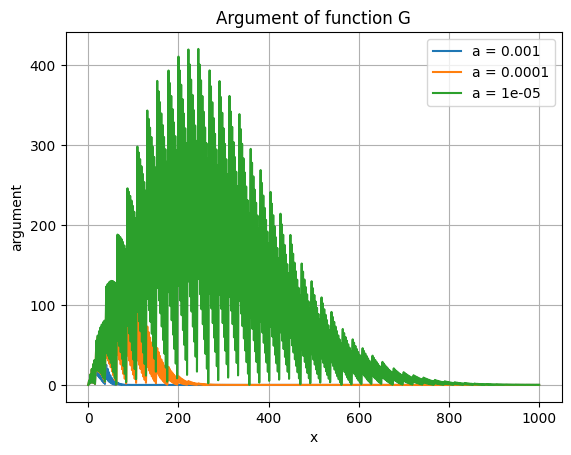

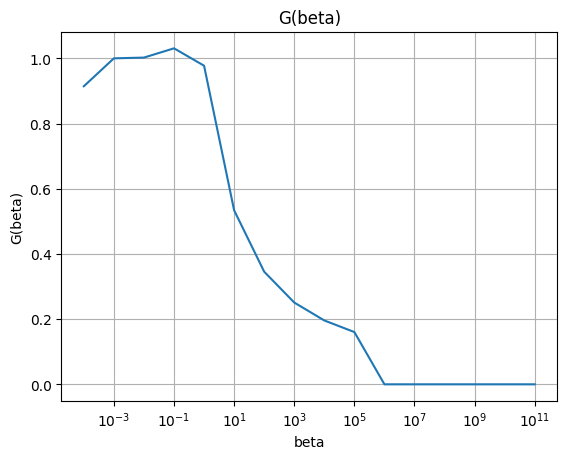

In [138]:
def argG(a, x):
    return x * np.exp(-a * x ** 2) * (np.pi / 2 + np.arctan(Y0(x)/J0(x)))
    

def G(beta):
    """Bennet and Patten (1962) function for constant head in well.
    
    Parameters
    ----------
    beta = kD t / r^2 S
    
    >>>G(0.004)
    9.41    
    """
    npoints = 50
    limit = 10 * npoints
    points = jn_zeros(0, npoints)
    def kernel(x, beta):
        """Return the function to be integrated."""
        return 4 * beta / np.pi * x * np.exp(-beta * x ** 2) * (np.pi / 2 + np.arctan(Y0(x) / J0(x)))
    def g(beta): # Integrate the argument
        return quad(kernel, 0., points[-1], args=(beta,), limit=limit, points=points)[0]
    gh = np.frompyfunc(g, 1, 1) # Vectorize function g(beta) so we can use arrays as input.
    return np.asarray(gh(beta), dtype=float)


x =np.linspace(0, 1000, 1000)
ax = newfig("Argument of function G", "x", "argument", yscale='linear')
for a in 10. ** -np.array([3, 4, 5]):
    ax.plot(x, argG(a, x), label=f"a = {a}")
ax.legend()

beta = np.logspace(-4, 11, 16)
ax = newfig("G(beta)", "beta", "G(beta)", xscale='log')
ax.plot(beta, G(beta))

print(np.log10(beta))
np.round(G(beta), 3)

De functie blijkt alleen integreerbaar voor beta > 1. Verschillende auteurs waarschuwen er ook voor dat integratie met de gewone methoden niet mogelijk is.